In [1]:
from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import pandas as pd
import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12):
    return (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

def gen_centers(X_test, n_clusters, d=2):
    if X_test.shape[0] >= n_clusters:
        KM = KMeans(n_clusters=n_clusters).fit(X_test)
        return KM.cluster_centers_
    else:
        return np.vstack([X_test, np.random.uniform(0,1,(n_clusters-X_test.shape[0],d))])

In [3]:
d = 2
sup = 1

n = 5_000
n_test = 100

# $\nu_{1} = \nu_{2} = 1/2$

In [4]:
nu_1 = 1/2
nu_2 = 1/2

## $\theta_{1} = 2$, $\theta_{2} = 2.5$

In [5]:
theta_1 = 2
theta_2 = 2.5

In [6]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

### EXTRA

In [9]:
X_1 = gen_observation_points(d, n + n_test, sup)
X_2 = gen_observation_points(d, n, sup)
sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]

X_test, Y_test = X_1[:n_test], Y_1[:n_test]
X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

sigma = sigma[n_test:, :][:, n_test:]

In [10]:
n_clusters = 20

In [11]:
coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, n // n_clusters, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
Y_pred = coKNN.predict(X_test)
root_mean_squared_error(Y_test, Y_pred)
# coKNN

0.17623945394757892

In [12]:
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)

A_1 = gen_A(X_1, n_clusters)
A_2 = gen_A(X_2, n_clusters)

Y_pred = NcoK.predict(X_test, A_1, A_2)
root_mean_squared_error(Y_test, Y_pred)
# KM DESORDENADO

0.17988341662915863

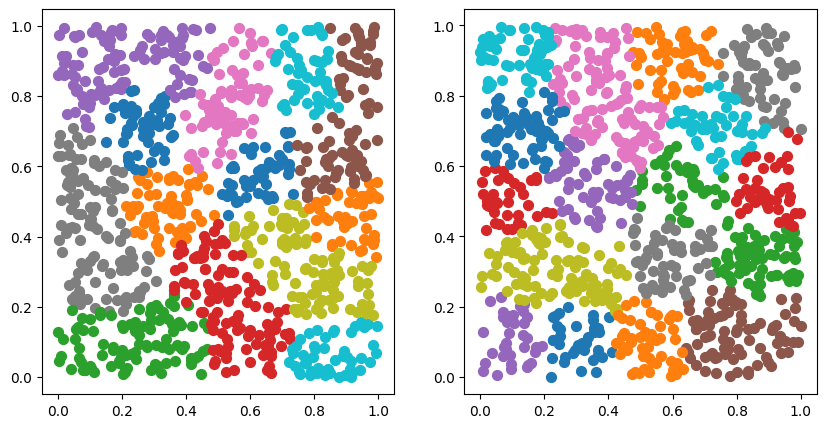

In [71]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

for l, j in zip(A_1, A_2):
    axs[0].scatter(X_1[l,0], X_1[l,1], s=50)
    axs[1].scatter(X_2[j,0], X_2[j,1], s=50)

In [13]:
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)

A_1, A_2 = gen_As(X_1, X_2, n_clusters)
Y_pred = NcoK.predict(X_test, A_1, A_2)
root_mean_squared_error(Y_test, Y_pred)
# KM ORDENADO

0.17271621022586447

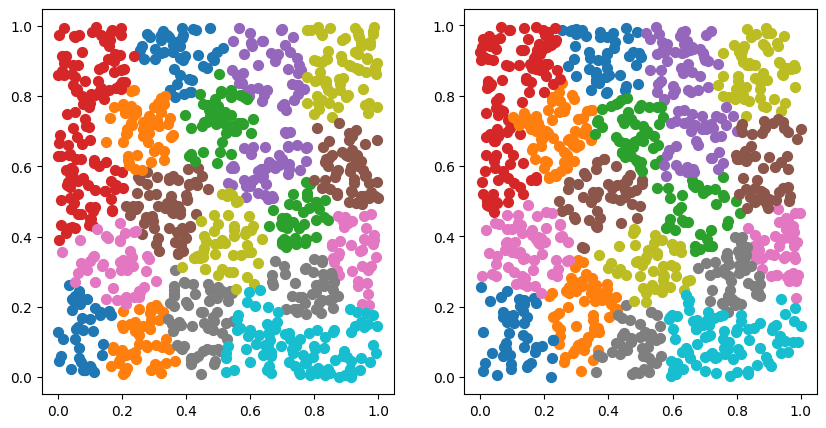

In [73]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

for l, j in zip(A_1, A_2):
    axs[0].scatter(X_1[l,0], X_1[l,1], s=50)
    axs[1].scatter(X_2[j,0], X_2[j,1], s=50)

In [ ]:
Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
root_mean_squared_error(Y_test, Y_pred)
# NN 

In [13]:
if X_test.shape[0] >= n_clusters:
    KM = KMeans(n_clusters=n_clusters).fit(X_test)

    A = [[] for _ in range(n_clusters)]
    for i, label in enumerate(KM.labels_):
        A[label].append(i)

    centers = KM.cluster_centers_
else:
    centers = np.vstack([X_test, np.random.uniform(0,1,(n_clusters-X_test.shape[0],d))])

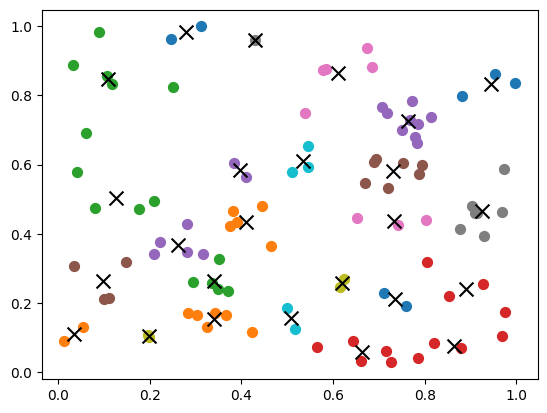

In [14]:
# plt.scatter(X_1[:,0], X_1[:,1], c='k', s=10);
if len(A)>0:
    for l in A:
        plt.scatter(X_test[l,0], X_test[l,1], s=50)
plt.scatter(centers[:,0], centers[:,1], c='k', marker='x', s=100);
# plt.scatter(X_test[:,0], X_test[:,1], c='r', marker='x');

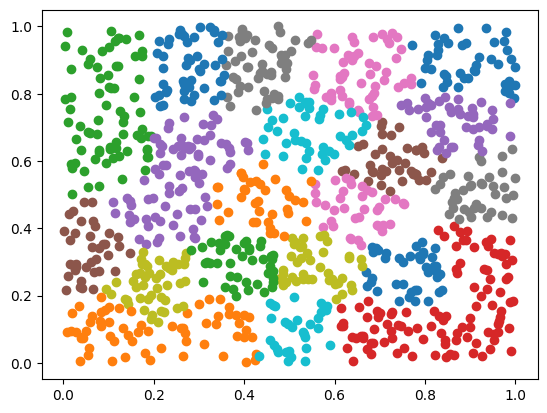

In [15]:
A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)

for l in A_1:
    plt.scatter(X_1[l,0], X_1[l,1])

In [16]:
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)

A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
Y_pred = NcoK.predict(X_test, A_1, A_2)
root_mean_squared_error(Y_test, Y_pred)

0.1741097988596686

In [131]:
# for l in A_1:
    # plt.scatter(X_1[l,0], X_1[l,1])

### Comparación NcoK (KM, KM+) y coKNN

In [7]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [8]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 12min 21s
1: 12min 7s
2: 11min 60s
3: 11min 48s
4: 11min 59s
5: 11min 51s
6: 11min 42s
7: 11min 51s
8: 11min 43s
9: 11min 49s
10: 11min 45s
11: 11min 45s
12: 11min 43s
13: 11min 48s
14: 11min 40s
15: 11min 39s
16: 11min 34s
17: 11min 36s
18: 11min 38s
19: 11min 40s
20: 11min 41s
21: 11min 33s
22: 11min 38s
23: 11min 37s
24: 11min 60s
25: 11min 39s
26: 11min 36s
27: 11min 50s
28: 11min 36s
29: 11min 31s
30: 11min 37s
31: 11min 37s
32: 11min 39s
33: 11min 33s
34: 11min 33s
35: 11min 35s
36: 11min 38s
37: 11min 57s
38: 11min 43s
39: 11min 37s
40: 11min 41s
41: 15min 21s
42: 11min 43s
43: 11min 33s
44: 11min 51s
45: 12min 37s
46: 14min 55s
47: 13min 12s
48: 11min 45s
49: 11min 47s


In [9]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['n'] = n
aux['nu_1'] = nu_1
aux['nu_2'] = nu_2
aux['theta_1'] = theta_1
aux['theta_2'] = theta_2

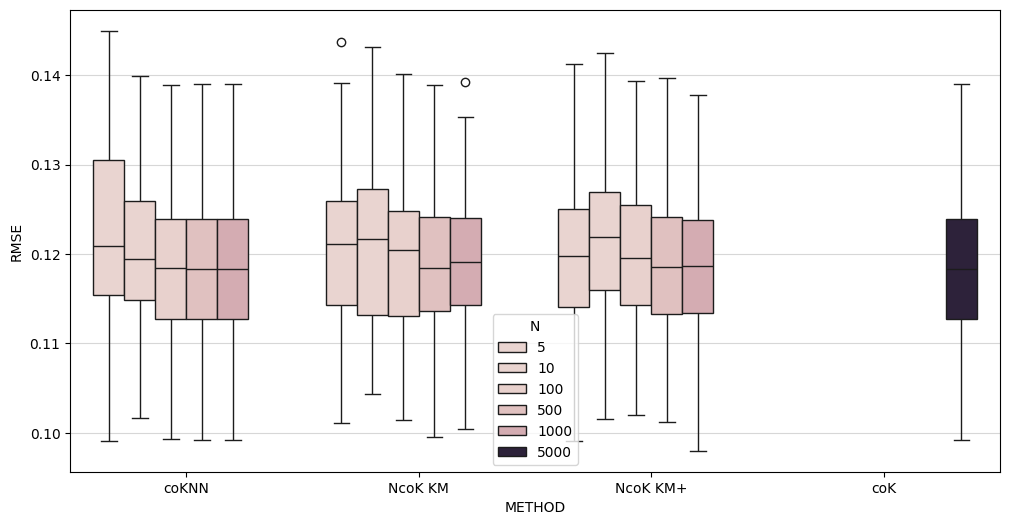

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='RMSE', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

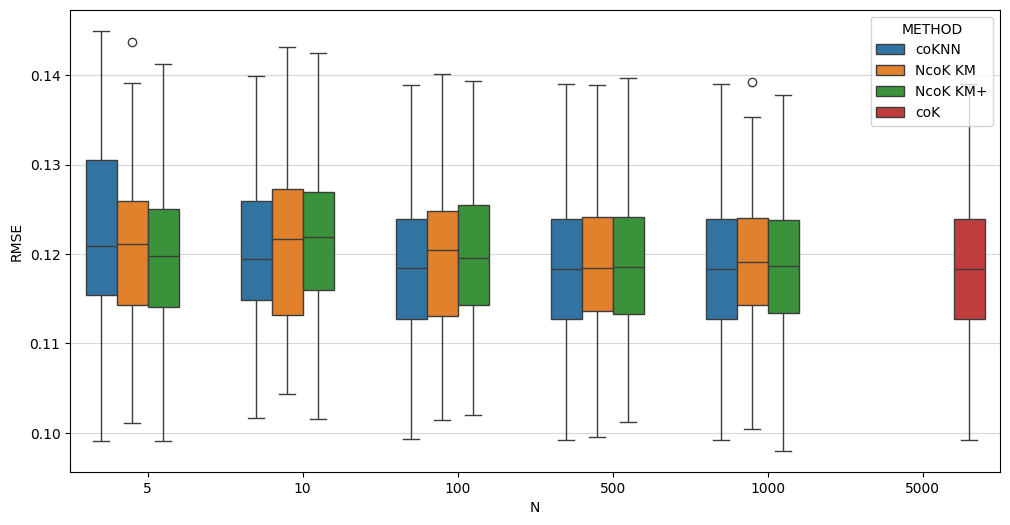

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='N', y='RMSE', hue='METHOD')
plt.grid(axis='y', alpha=0.5, zorder=1);

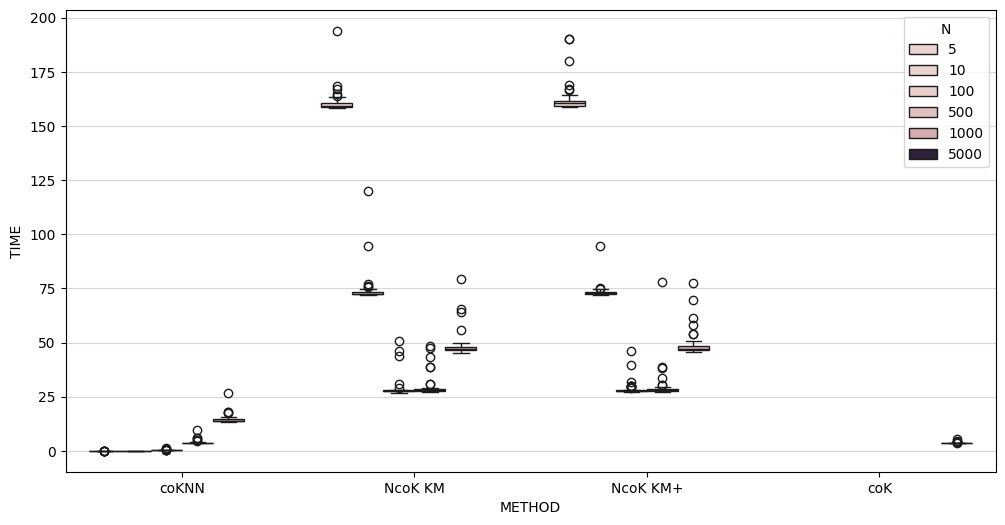

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='TIME', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [13]:
data = pd.read_csv('experimentos_d2.csv', sep=';')
data.head()

,METHOD,N,K,TIME,RMSE,n,nu_1,nu_2,theta_1,theta_2
0,coKNN,1000,5,16.380401,0.135436,5000,0.5,0.5,4,5
1,NcoK KM,1000,5,55.742119,0.138959,5000,0.5,0.5,4,5
2,NcoK KM+,1000,5,56.342389,0.136346,5000,0.5,0.5,4,5
3,coKNN,500,10,4.216903,0.135433,5000,0.5,0.5,4,5
4,NcoK KM,500,10,32.773331,0.136421,5000,0.5,0.5,4,5


In [14]:
data = pd.concat([aux, data], axis=0)

In [15]:
data.to_csv('experimentos_d2.csv', index=False, sep=';')

## $\theta_{1} = 4$, $\theta_{2} = 5$

In [7]:
theta_1 = 4
theta_2 = 5

In [8]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [20]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [21]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 13min 1s
1: 13min 0s
2: 13min 3s
3: 12min 58s
4: 12min 57s
5: 13min 14s
6: 13min 2s
7: 13min 3s
8: 13min 10s
9: 13min 0s
10: 13min 5s
11: 13min 16s
12: 13min 26s
13: 13min 3s
14: 13min 7s
15: 13min 14s
16: 13min 5s
17: 13min 4s
18: 13min 3s
19: 13min 19s
20: 13min 6s
21: 13min 8s
22: 13min 20s
23: 13min 8s
24: 13min 5s
25: 13min 57s
26: 14min 24s
27: 13min 12s
28: 13min 14s
29: 13min 43s
30: 13min 16s
31: 13min 18s
32: 13min 27s
33: 13min 18s
34: 13min 18s
35: 13min 33s
36: 13min 37s
37: 13min 23s
38: 13min 30s
39: 13min 40s
40: 13min 26s
41: 13min 31s
42: 13min 35s
43: 13min 40s
44: 13min 30s
45: 13min 39s
46: 13min 49s
47: 13min 36s
48: 13min 28s
49: 13min 42s


In [22]:
data = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

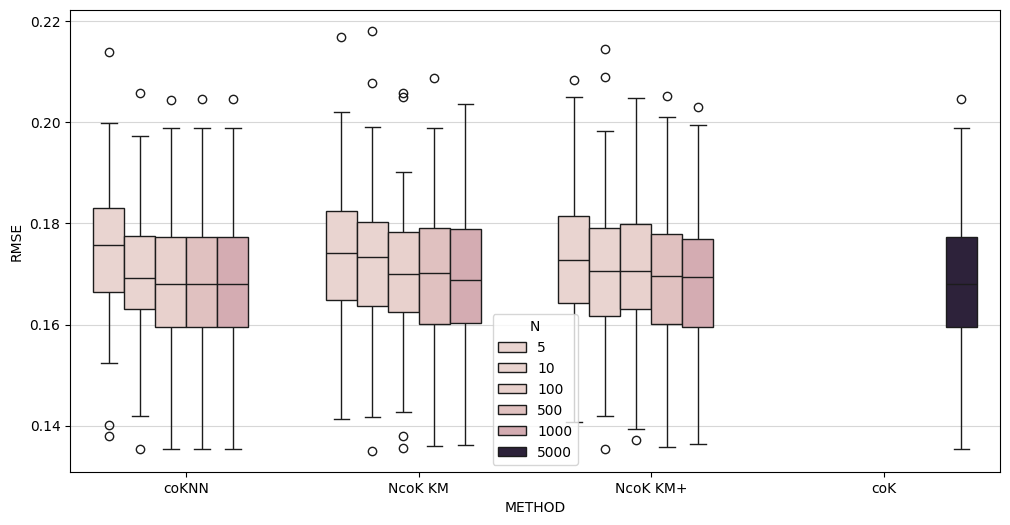

In [23]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x='METHOD', y='RMSE', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

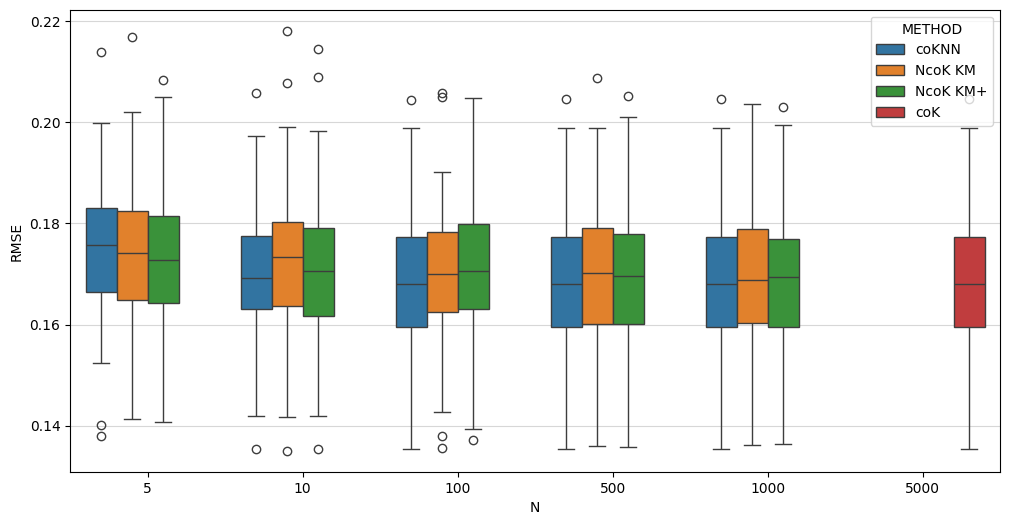

In [24]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x='N', y='RMSE', hue='METHOD')
plt.grid(axis='y', alpha=0.5, zorder=1);

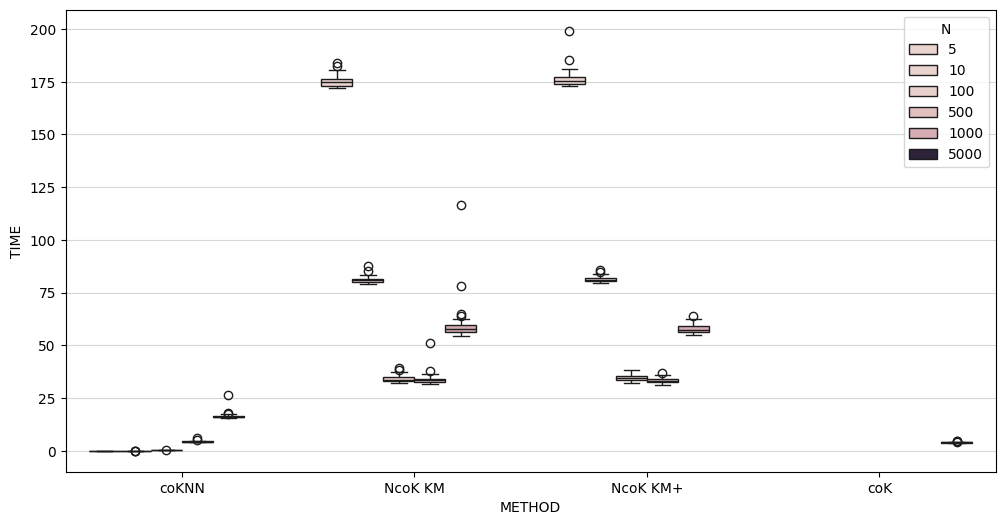

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x='METHOD', y='TIME', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [28]:
data.to_csv('experimentos_d2.csv', index=False, sep=';')

# $\theta_1 = 4$, $\theta_2 = 5$

In [29]:
theta_1 = 4
theta_2 = 5

## $\nu_{1} = 1/2, \nu_{2} = 5/2$

In [30]:
nu_1 = 1/2
nu_2 = 5/2

In [31]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.5962847939999439

In [32]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [33]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 15min 16s
1: 14min 37s
2: 14min 20s
3: 14min 36s
4: 14min 41s
5: 14min 21s
6: 14min 44s
7: 15min 12s
8: 14min 38s
9: 14min 43s
10: 15min 3s
11: 14min 49s
12: 14min 40s
13: 15min 5s
14: 14min 52s
15: 14min 49s
16: 15min 6s
17: 15min 1s
18: 14min 45s
19: 15min 9s
20: 15min 12s
21: 14min 52s
22: 15min 11s
23: 15min 9s
24: 14min 47s
25: 15min 17s
26: 15min 20s
27: 15min 9s
28: 15min 13s
29: 15min 18s
30: 15min 4s
31: 14min 57s
32: 15min 16s
33: 15min 2s
34: 15min 0s
35: 15min 22s
36: 15min 4s
37: 15min 1s
38: 15min 23s
39: 15min 5s
40: 15min 3s
41: 15min 27s
42: 15min 8s
43: 15min 0s
44: 15min 31s
45: 15min 18s
46: 15min 30s
47: 21min 55s
48: 15min 32s
49: 15min 32s


In [34]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['n'] = n
aux['nu_1'] = nu_1
aux['nu_2'] = nu_2
aux['theta_1'] = theta_1
aux['theta_2'] = theta_2

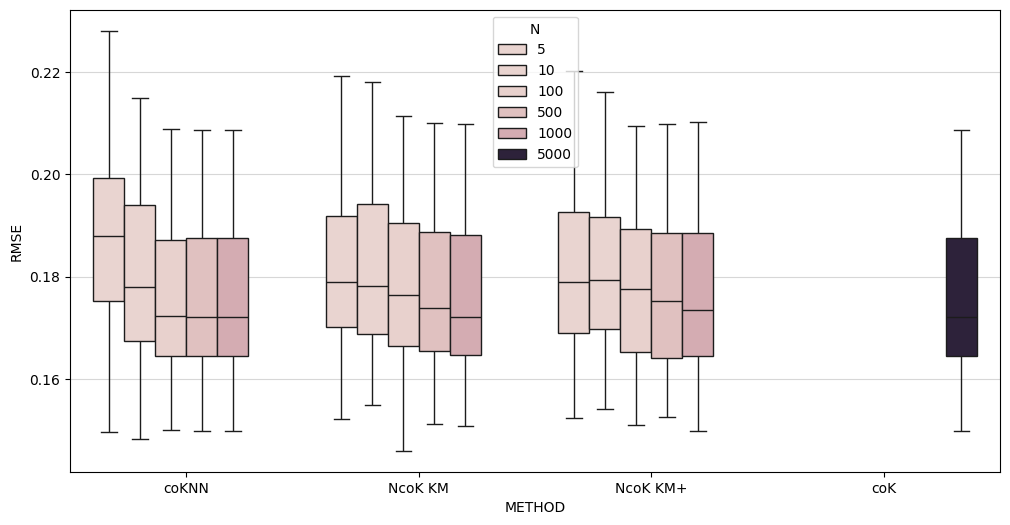

In [35]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='RMSE', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

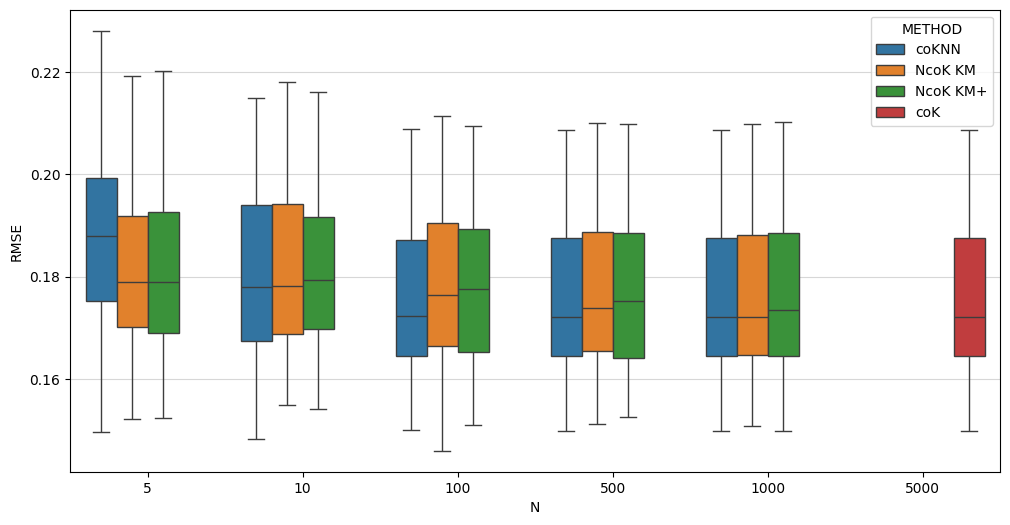

In [36]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='N', y='RMSE', hue='METHOD')
plt.grid(axis='y', alpha=0.5, zorder=1);

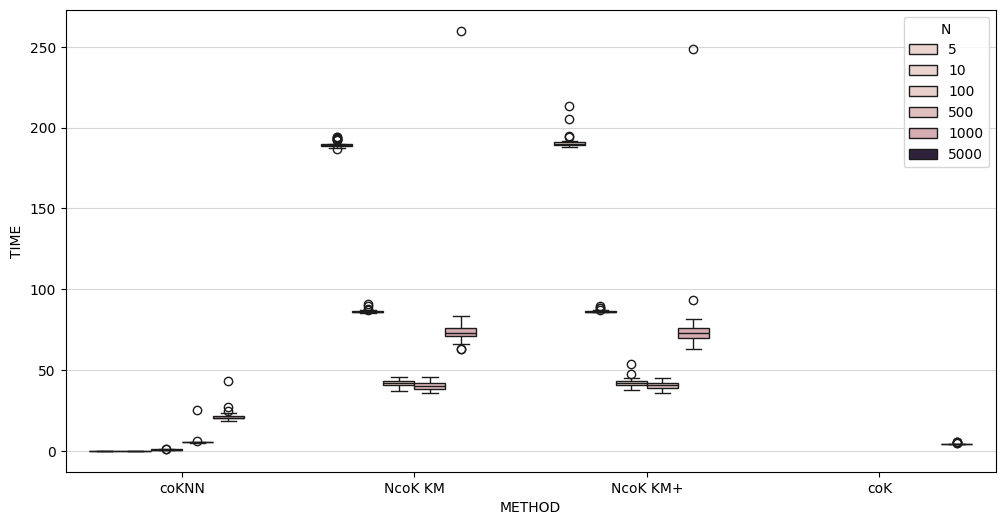

In [37]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='TIME', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [44]:
data = pd.read_csv('experimentos_d2.csv', sep=';')
data.head()

,METHOD,N,K,TIME,RMSE,n,nu_1,nu_2,theta_1,theta_2
0,coKNN,1000,5,16.380401,0.135436,5000,0.5,0.5,4,5
1,NcoK KM,1000,5,55.742119,0.138959,5000,0.5,0.5,4,5
2,NcoK KM+,1000,5,56.342389,0.136346,5000,0.5,0.5,4,5
3,coKNN,500,10,4.216903,0.135433,5000,0.5,0.5,4,5
4,NcoK KM,500,10,32.773331,0.136421,5000,0.5,0.5,4,5


In [45]:
data = pd.concat([data, aux], axis=0)

In [46]:
data.to_csv('experimentos_d2.csv', index=False, sep=';')

## $\nu_{1} = 5/2, \nu_{2} = 1/2$

In [48]:
nu_1 = 5/2
nu_2 = 1/2

In [49]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.5962847939999439

In [50]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [52]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 17min 20s
1: 16min 28s
2: 17min 10s
3: 17min 11s
4: 16min 21s
5: 17min 54s
6: 17min 9s
7: 17min 6s
8: 17min 17s
9: 16min 47s
10: 17min 29s
11: 17min 28s
12: 16min 31s
13: 17min 34s
14: 17min 39s
15: 17min 34s
16: 18min 7s
17: 16min 37s
18: 17min 58s
19: 17min 42s
20: 17min 14s
21: 17min 52s
22: 17min 17s
23: 17min 56s
24: 18min 6s
25: 17min 4s
26: 18min 8s
27: 17min 59s
28: 18min 19s
29: 18min 18s
30: 17min 13s
31: 18min 36s
32: 18min 19s
33: 18min 37s
34: 18min 46s
35: 17min 35s
36: 18min 58s
37: 18min 27s
38: 19min 12s
39: 18min 13s
40: 18min 5s
41: 18min 4s
42: 17min 37s
43: 18min 36s
44: 18min 36s
45: 18min 10s
46: 18min 22s
47: 17min 49s
48: 18min 55s
49: 18min 46s


In [53]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['n'] = n
aux['nu_1'] = nu_1
aux['nu_2'] = nu_2
aux['theta_1'] = theta_1
aux['theta_2'] = theta_2

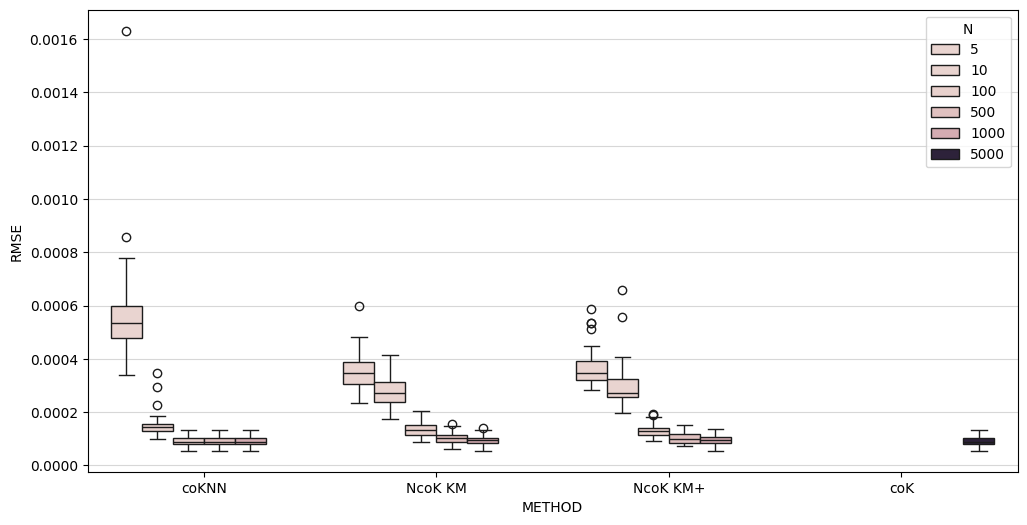

In [54]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='RMSE', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

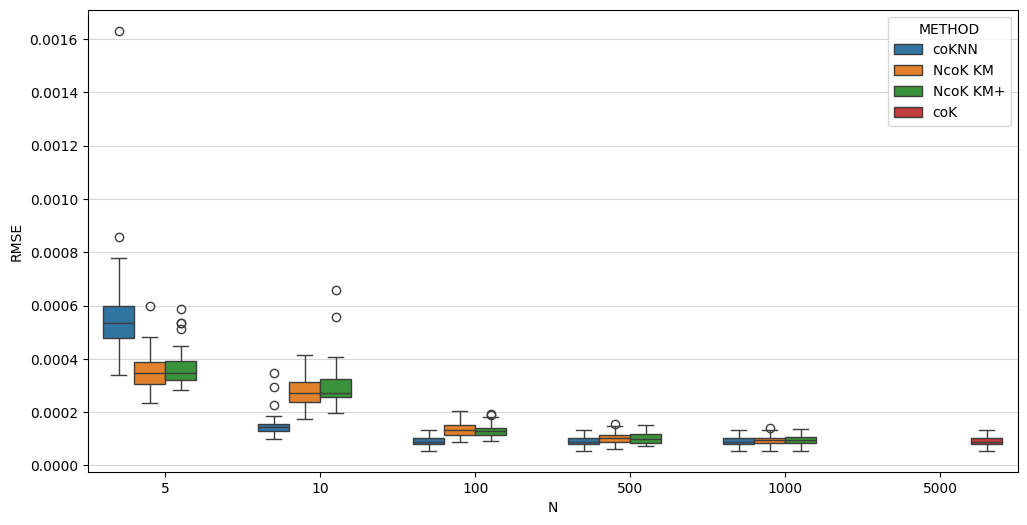

In [55]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='N', y='RMSE', hue='METHOD')
plt.grid(axis='y', alpha=0.5, zorder=1);

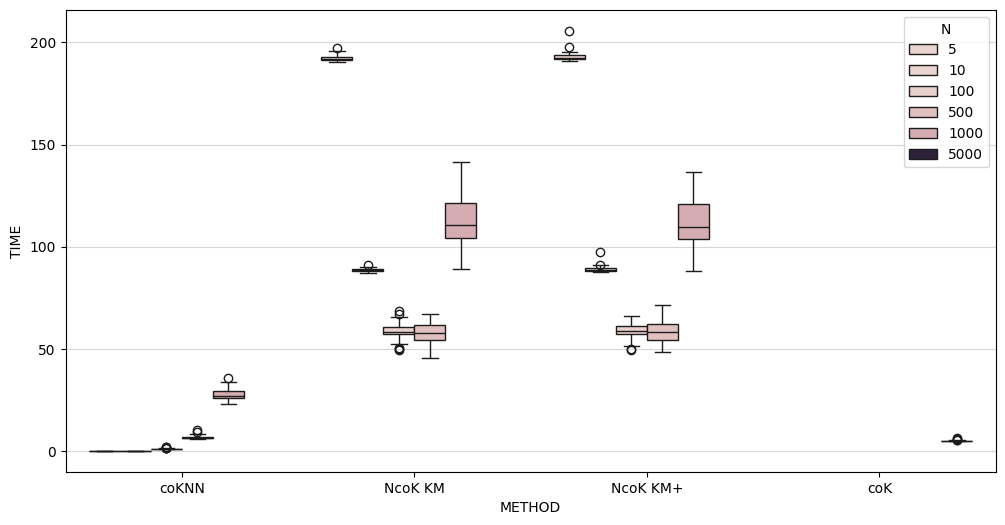

In [56]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='TIME', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [57]:
data = pd.read_csv('experimentos_d2.csv', sep=';')
data.head()

,METHOD,N,K,TIME,RMSE,n,nu_1,nu_2,theta_1,theta_2
0,coKNN,1000,5,16.380401,0.135436,5000,0.5,0.5,4,5
1,NcoK KM,1000,5,55.742119,0.138959,5000,0.5,0.5,4,5
2,NcoK KM+,1000,5,56.342389,0.136346,5000,0.5,0.5,4,5
3,coKNN,500,10,4.216903,0.135433,5000,0.5,0.5,4,5
4,NcoK KM,500,10,32.773331,0.136421,5000,0.5,0.5,4,5


In [58]:
data = pd.concat([data, aux], axis=0)

In [59]:
data.to_csv('experimentos_d2.csv', index=False, sep=';')

## $\nu_{1} = 5/2, \nu_{2} = 5/2$

In [60]:
nu_1 = 5/2
nu_2 = 5/2

In [61]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [62]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [63]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 18min 42s
1: 18min 46s
2: 17min 46s
3: 18min 24s
4: 18min 20s
5: 19min 16s
6: 19min 51s
7: 18min 51s
8: 18min 12s
9: 18min 2s
10: 20min 20s
11: 19min 58s
12: 19min 51s
13: 20min 52s
14: 23min 38s
15: 23min 18s
16: 24min 4s
17: 24min 26s
18: 24min 1s
19: 24min 59s
20: 23min 31s
21: 25min 36s
22: 22min 50s
23: 27min 57s
24: 22min 26s
25: 26min 48s
26: 24min 60s
27: 27min 34s
28: 28min 16s
29: 24min 20s
30: 28min 24s
31: 23min 53s
32: 24min 58s
33: 27min 10s
34: 27min 10s
35: 29min 10s
36: 24min 48s
37: 26min 12s
38: 27min 11s
39: 28min 10s
40: 31min 9s
41: 26min 44s
42: 27min 29s
43: 34min 17s
44: 28min 58s
45: 29min 46s
46: 34min 46s
47: 29min 35s
48: 31min 50s
49: 34min 25s


In [64]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['n'] = n
aux['nu_1'] = nu_1
aux['nu_2'] = nu_2
aux['theta_1'] = theta_1
aux['theta_2'] = theta_2

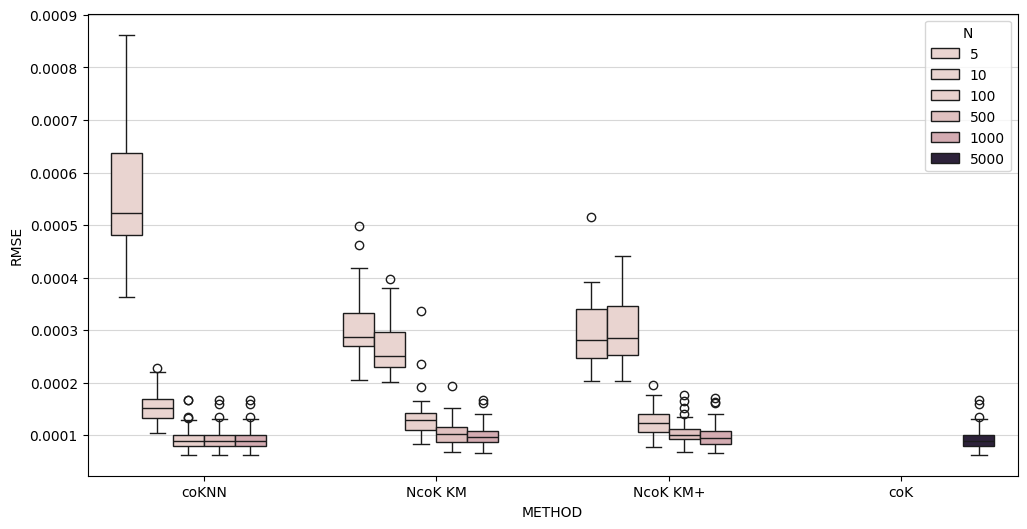

In [65]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='RMSE', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

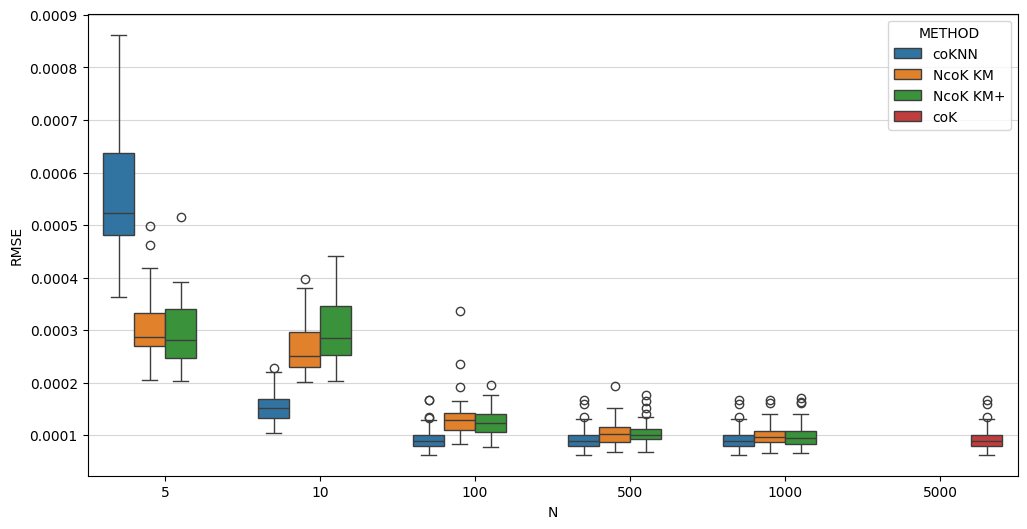

In [66]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='N', y='RMSE', hue='METHOD')
plt.grid(axis='y', alpha=0.5, zorder=1);

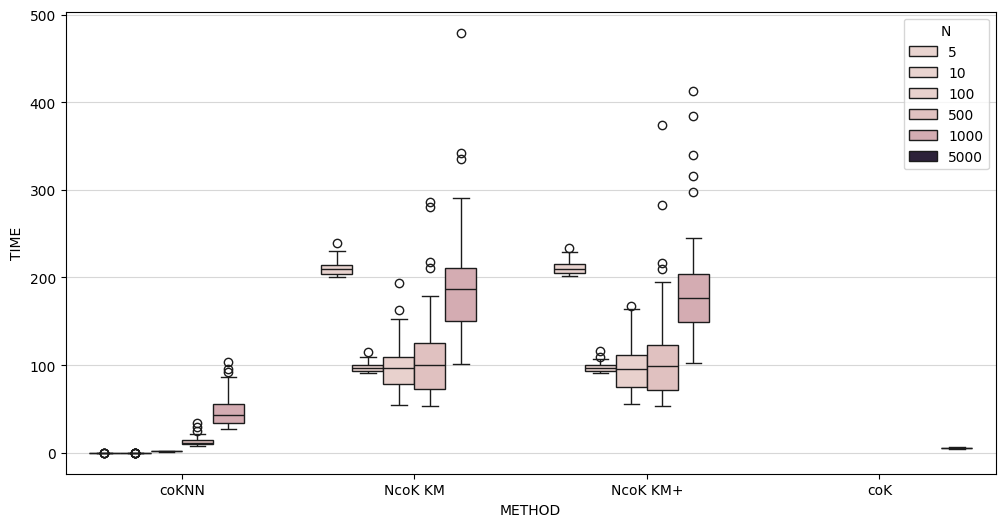

In [67]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='TIME', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [68]:
data = pd.read_csv('experimentos_d2.csv', sep=';')
data.head()

,METHOD,N,K,TIME,RMSE,n,nu_1,nu_2,theta_1,theta_2
0,coKNN,1000,5,16.380401,0.135436,5000,0.5,0.5,4,5
1,NcoK KM,1000,5,55.742119,0.138959,5000,0.5,0.5,4,5
2,NcoK KM+,1000,5,56.342389,0.136346,5000,0.5,0.5,4,5
3,coKNN,500,10,4.216903,0.135433,5000,0.5,0.5,4,5
4,NcoK KM,500,10,32.773331,0.136421,5000,0.5,0.5,4,5


In [69]:
data = pd.concat([data, aux], axis=0)

In [70]:
data.to_csv('experimentos_d2.csv', index=False, sep=';')